1. Have a simulated image


2. Use HSS to find a stream


3. Rotate to the stream coordinate frame and make a cutout


4. Apply Gabby's code to find the stream --> by boostrapping PiHPi


5. Compute gap detection threshold 

In [1]:
#imports 

import astropy.units as u
import numpy as np
import popsims #custom libray for plotting aesthetics
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm

#import HSS
import seaborn as sns
import matplotlib as mpl

import astropy.coordinates as astro_coord
import glob
import pandas as pd
#sns.set_style("dark")
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {'axes.titlesize'      : 'large',   # fontsize of the axes title
        'axes.labelsize'      : 'large', # fontsize of the x any y labels
        'size'   : 20}


import itertools
from scipy import stats
from shapey import Box
#paths
path_plot = '/users/caganze/research/stellarstreams/figures/paper/'
#path_data = '/users/caganze/research/stellarstreams/data/rotating/'
path_data = '/users/caganze/research/stellarstreams/data/stream/'
isochrone_path='/users/caganze/research/stellarstreams/data/isochrones/'


In [2]:
def detect_gap_by_boostrap(bws, data, xlims, ylims, min_max_scale=False):
    
    """
    Purpose detect gap by bootstrapping and using an median over several bandwidths
    
    """
    min_bw= 0.05
    
    #Boundaries for the Gapper (if none are provided, this is the default mode)
    bounds = np.array([[np.min(data[:,d]),np.max(data[:,d])] for d in range(data.shape[1])])

    gridding_size = [ int((xlims[1]-xlims[0])/min_bw), int((ylims[1]-ylims[0])/min_bw)]

    grid_linspace = [ np.linspace(bounds[d][0], bounds[d][1], gridding_size[d]) for d in range(2) ]
    #could use a rectangular grid instead


    meshgrid = np.meshgrid(*grid_linspace, indexing='ij')

    meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in meshgrid]
    grid_data = np.hstack(meshgrid_ravel)
    

    res=dict(zip(bws, [None for x in bws]))

    for bw in bws:

        #run for multiple bandwidths
        gapper_base = Gapper(data, bw, bounds)

        #compute density along the grid 
        grid_density = gapper_base.kde.score_samples(torch.tensor(grid_data))

        #density matrix 
        density_matr = grid_density.reshape((gridding_size[0], gridding_size[1]))

        #compute piHpi matrix by bootstraping
        maxeigval_PiHPi_boots = []
        
        #median PiHPi
        PiHPi_boots=[]
        for i in range(5):

            boot_indx = np.random.choice(np.arange(data.shape[0]), data.shape[0], 
                                         replace=True) ## Sample with replacement:bootstrap

            gapper_ = Gapper(data[boot_indx], bw, bounds)
            PiHPis_grid = []
            eigval_PiHPi = [] 

            for pt in grid_data:
                _pihpi = gapper_.get_PiHPi(pt) 
                _pihpi_eigval, _pihpi_eigvec = np.linalg.eigh(_pihpi)

                PiHPis_grid.append(_pihpi)
                eigval_PiHPi.append(_pihpi_eigval)

            PiHPis_grid, eigval_PiHPi = np.array(PiHPis_grid), np.array(eigval_PiHPi)
            max_eigval_PiHPi_k = np.max(eigval_PiHPi, axis=1)
            maxeigval_PiHPi_boots.append(max_eigval_PiHPi_k)
            PiHPi_boots.append(PiHPis_grid)
            print(f'Run {i} finished')

        #visualize and take the median
        maxeigval_PiHPi_boots = np.array(maxeigval_PiHPi_boots)
        print(maxeigval_PiHPi_boots.shape)

        #median
        med_maxeigval_pihpi = np.median(maxeigval_PiHPi_boots, axis=0)


        med_maxeigval_pihpi_resh = med_maxeigval_pihpi.reshape((gridding_size[0], gridding_size[1]))


        res[bw]= {'density':density_matr, \
                  'max_eigen':med_maxeigval_pihpi_resh,
                  'meshgrid':meshgrid, 
                  'PiHPi': PiHPi_boots}

    return res
    
def get_cutout_m31(rgc, mhalo, mag_limit):
    filename=path_data+'/gaps_at_M31{} mlimit {}Mhalo={:.2e}_cutout'.format(rgc, mag_limit, mhalo) 
    return pd.read_csv(filename).values
                       
    
def get_cutout_distance(mhalo, mag_limit, dmod):
    filename=path_data+'/gaps_at_OTHER{}Mhalo={:.2e}_maglimit{}_cutout.txt'.format(dmod, mhalo, mag_limit)
    
    return pd.read_csv(filename).values

In [3]:
mhalo=5e6
mag_limit=28.54

In [4]:
bws=np.array([0.01, 0.025, 0.05, 0.075, 0.1])*10
rgcs=['10_20', '30_40', '50_60']

In [5]:
from findthegap.gapper import Gapper
import torch

In [6]:
idx=-1
data=get_cutout_m31(rgcs[idx], mhalo, mag_limit)
xlims=[data[:,0].min(), data[:,0].max()]
ylims=[data[:,1].min(), data[:,1].max()]
dens=  detect_gap_by_boostrap(bws, data, xlims, ylims)

Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
(5, 4495)
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
(5, 4495)
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
(5, 4495)
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
(5, 4495)
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
(5, 4495)


In [7]:
import matplotlib.ticker as tick

In [8]:
path_plot

'/users/caganze/research/stellarstreams/figures/paper/'

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


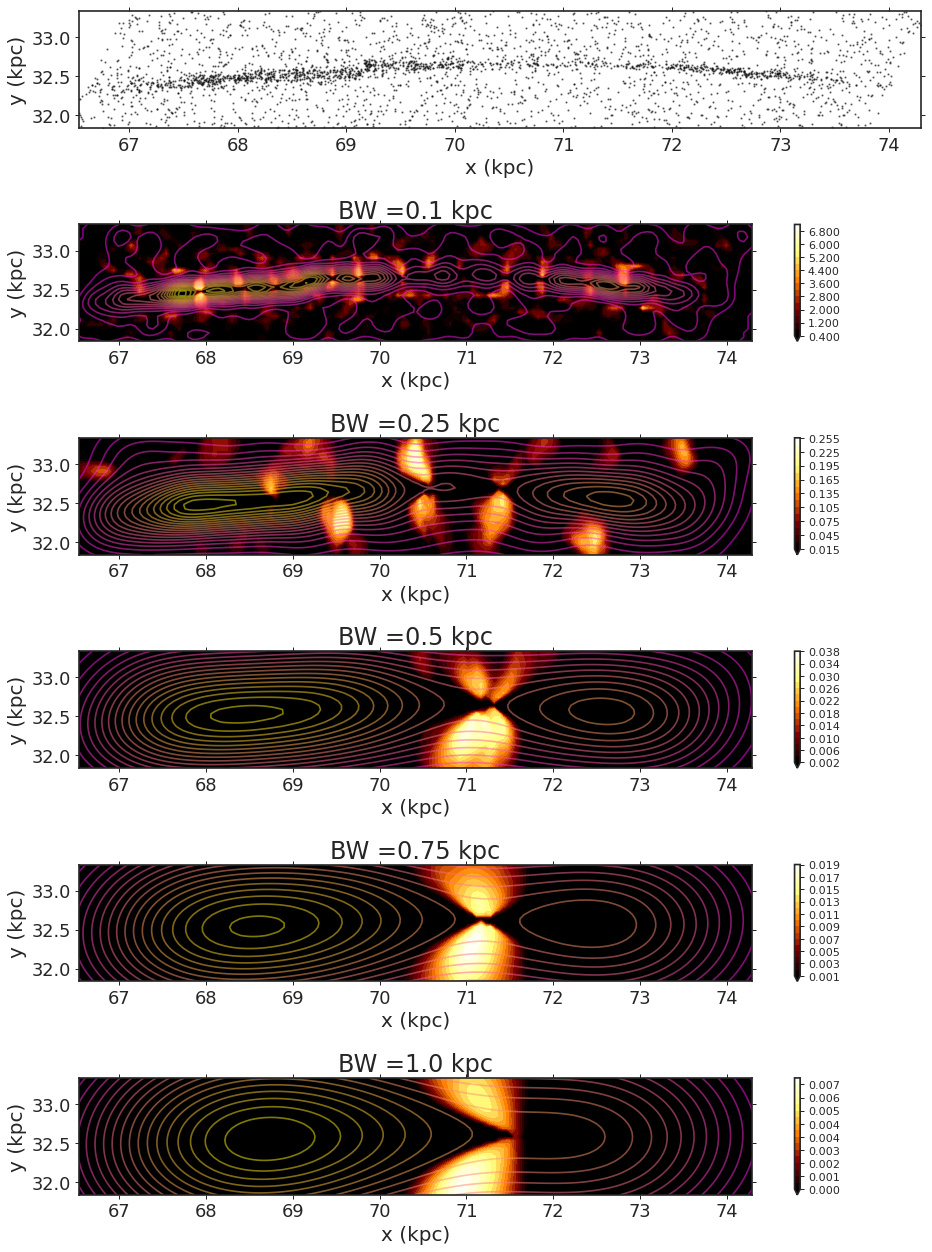

In [9]:
fig, ax=plt.subplots(nrows=len(dens.keys())+1, figsize=(12, 16))

ax[0].scatter(data[:,0], data[:,1], s=1, alpha=.5, color='#111111')

for idx, k in enumerate(dens.keys()):
    meshgrid= dens[k]['meshgrid']

    ax[idx+1].contour(meshgrid[0], meshgrid[1],  dens[k]['density'],  20, \
                      cmap='spring', alpha=.5)
    p= ax[idx+1].contourf(meshgrid[0], meshgrid[1], dens[k]['max_eigen'],\
                        20, cmap='afmhot',  extend='min')
    ax[idx+1].set_title('BW ={} kpc'.format(bws[idx]))
    
    cbar=plt.colorbar(p, ax=ax[idx+1])
    cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(10)
    
    
for a in ax:
    a.set(xlabel='x (kpc)', ylabel='y (kpc)', xlim=xlims, ylim=ylims)
plt.tight_layout()
plt.savefig(path_plot+'/gaps_changing_bandwidths_mag28.pdf', bbox_inches='tight')

In [10]:
np.round(np.ptp(data[:,0])),  np.round(np.ptp(data[:,1]))

(8.0, 1.0)

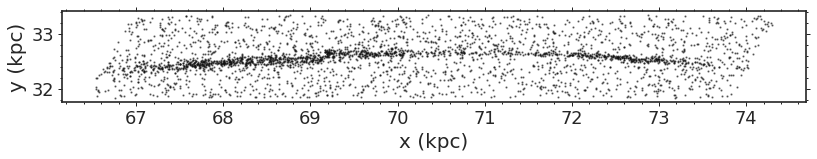

In [11]:
fig, ax=plt.subplots( figsize=(8*1.5, 1*1.5))

ax.scatter(data[:,0], data[:,1], s=1, alpha=.5, color='#111111')
ax.set(xlabel='x (kpc)', ylabel='y (kpc)')
plt.minorticks_on()
plt.savefig(path_plot+'/example_gaps.jpeg', bbox_inches='tight')

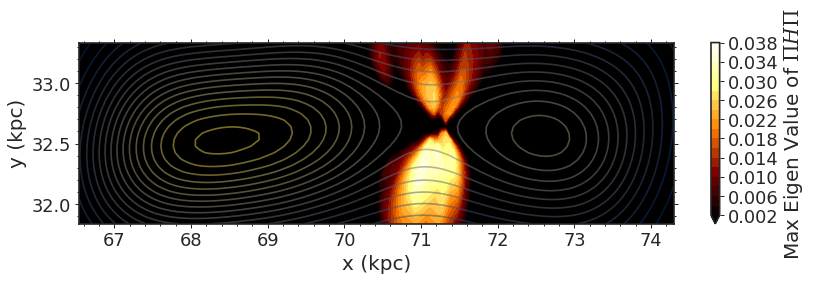

In [12]:
fig, ax=plt.subplots( figsize=(8*1.5, 2*1.5))

k=0.5

meshgrid= dens[k]['meshgrid']

ax.contour(meshgrid[0], meshgrid[1],  dens[k]['density'],  20, \
                  cmap='cividis', alpha=.5)

p= ax.contourf(meshgrid[0], meshgrid[1], dens[k]['max_eigen'],\
                        20, cmap='afmhot',  extend='min')
plt.colorbar(p, label=r'Max Eigen Value of $\Pi H \Pi$')
ax.set(xlabel='x (kpc)', ylabel='y (kpc)')
plt.minorticks_on()
plt.savefig(path_plot+'/example_gaps_piHPI.jpeg', bbox_inches='tight')

In [13]:
#try this with the same setup but fewer stars i.e mag limit lower
mhalo=5e6
mag_limit=27.15
idx=-1
data=get_cutout_m31(rgcs[idx], mhalo, mag_limit)
xlims=[data[:,0].min(), data[:,0].max()]
ylims=[data[:,1].min(), data[:,1].max()]
dens2=  detect_gap_by_boostrap(bws, data, xlims, ylims)

Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
(5, 4524)
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
(5, 4524)
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
(5, 4524)
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
(5, 4524)
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
(5, 4524)


TypeError: Shapes of x (156, 29) and z (155, 29) do not match

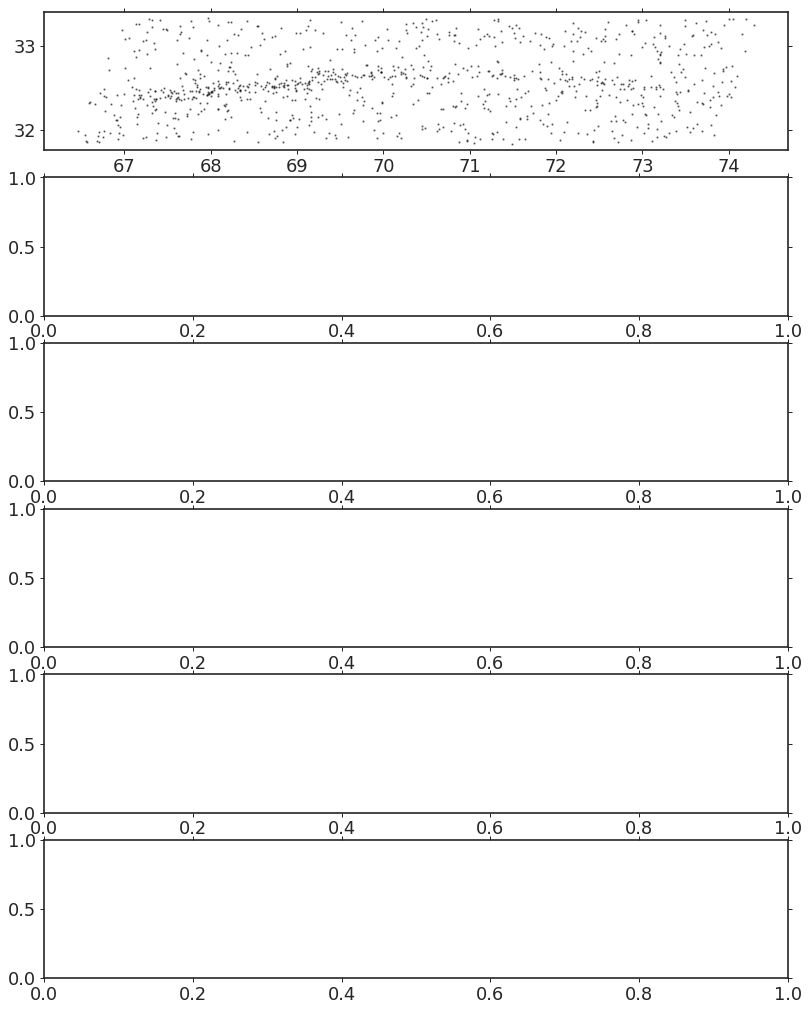

In [14]:
fig, ax=plt.subplots(nrows=len(dens.keys())+1, figsize=(12, 16))

ax[0].scatter(data[:,0], data[:,1], s=1, alpha=.5, color='#111111')

for idx, k in enumerate(dens.keys()):
    meshgrid= dens2[k]['meshgrid']

    ax[idx+1].contour(meshgrid[0], meshgrid[1],  dens[k]['density'],  20, \
                      cmap='spring', alpha=.5)
    p= ax[idx+1].contourf(meshgrid[0], meshgrid[1], dens[k]['max_eigen'],\
                        20, cmap='afmhot', extend='min')
    ax[idx+1].set_title('BW ={} kpc'.format(bws[idx]))
    
    cbar=plt.colorbar(p, ax=ax[idx+1],  label=f"$\Pi H \Pi$")
    cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))
    
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(10)
    
    
for a in ax:
    a.set(xlabel='x (kpc)', ylabel='y (kpc)', xlim=xlims, ylim=ylims)
plt.tight_layout()
plt.savefig(path_plot+'/gaps_changing_bandwidths_mag27.pdf', bbox_inches='tight')

In [ ]:
#use gappy to find the true location of the gap

In [ ]:
dens[0.5]['max_eigen']

In [ ]:
#choose points above 90-percentile 
s=np.percentile(dens[0.5]['max_eigen'].flatten(), 90)

In [ ]:
dens[0.5]['max_eigen']> s